In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set style for the plots
plt.style.use('seaborn-v0_8')


In [82]:
df = pd.read_csv('../data/processed/water_levels_daily.csv', parse_dates=['timestamp'])
weekly = (
    df.set_index("timestamp")["value"]
      .resample("W-SUN").mean()
      .interpolate()
)

In [83]:
periods = [52]
t = np.arange(len(weekly))
fourier_terms = pd.DataFrame(index=weekly.index)
for P in periods:
    fourier_terms[f"sin_{P}w"] = np.sin(2 * np.pi * t / P)
    fourier_terms[f"cos_{P}w"] = np.cos(2 * np.pi * t / P)
    
    
anchor_template  = [
    ("11-01", 237.30), ("12-15", 237.30), ("01-01", 239.61),
    ("02-01", 241.71), ("03-01", 242.70), ("04-01", 244.10),
    ("05-01", 244.95),
]

def compute_max_level_series(dates):
    # (Keep the function definition from your SARIMA code)
    def max_level_on(date):
        y0 = date.year if date.month >= 11 else date.year - 1
        pts = []
        for md, lvl in anchor_template:
            mon, day = map(int, md.split("-"))
            year = y0 if mon >= 11 else y0 + 1
            # Handle potential errors creating timestamps (e.g., Feb 29)
            try:
                pts.append((pd.Timestamp(year, mon, day), lvl))
            except ValueError: # Skip invalid dates like Feb 29 in non-leap years if needed
                 if mon == 2 and day == 29:
                     pts.append((pd.Timestamp(year, 2, 28), lvl)) # Use Feb 28 instead
                 else:
                     raise # Re-raise other errors
        pts.sort(key=lambda x: x[0])
        if date < pts[0][0] or date >= pts[-1][0]:
            return pts[-1][1]
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= date <= d1:
                frac = (date - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        return pts[-1][1] # Fallback

    return pd.Series([max_level_on(d) for d in dates], index=dates, name="max_level_m")

max_level = compute_max_level_series(weekly.index)

# Combine features
data_full = pd.concat([weekly.rename('value'), fourier_terms], axis=1)

In [84]:
data_full

,value,sin_52w,cos_52w
timestamp,,,
2000-01-02,239.520000,0.000000,1.000000
2000-01-09,239.284286,0.120537,0.992709
2000-01-16,239.102857,0.239316,0.970942
2000-01-23,239.188571,0.354605,0.935016
2000-01-30,239.548571,0.464723,0.885456
...,...,...,...
2025-03-30,242.511429,0.885456,-0.464723
2025-04-06,242.427143,0.822984,-0.568065
2025-04-13,242.101429,0.748511,-0.663123


In [85]:
validation_start_date = '2018-01-01'
validation_end_date = '2020-12-31'

train_data = data_full[:validation_start_date]
valid_data = data_full[validation_start_date:validation_end_date]
test_data = data_full[validation_end_date:]

# Also get the validation/test target values and max_levels for later evaluation/capping
actual_valid_values = weekly[validation_start_date:]
max_level_valid = max_level[validation_start_date:]
actual_test_values = weekly[validation_end_date:]
max_level_test = max_level[validation_end_date:]

len(train_data) / len(data_full), len(valid_data) / len(data_full), len(test_data) / len(data_full)

(0.7110438729198184, 0.11800302571860817, 0.17095310136157338)

In [86]:
# Scaler for input features (X) - includes 'value' column for lagged inputs
scaler_X = MinMaxScaler()
# Fit on the entire training data (all columns that will form the input sequences)
scaler_X.fit(train_data)

# Scaler for the target variable (y) - only the 'value' column
scaler_y = MinMaxScaler()
# Fit requires a 2D array, so reshape the 'value' column
scaler_y.fit(train_data[['value']]) # Use double brackets to keep it as DataFrame -> 2D

# Transform the data using the appropriate scalers
train_scaled = scaler_X.transform(train_data)
valid_scaled = scaler_X.transform(valid_data)

# Convert back to DataFrames for creating sequences
# Use the original columns for clarity
train_scaled_df = pd.DataFrame(train_scaled, index=train_data.index, columns=train_data.columns)
valid_scaled_df = pd.DataFrame(valid_scaled, index=valid_data.index, columns=valid_data.columns)

In [87]:
def create_sequences_separate(input_data_scaled_X, # Data scaled by scaler_X
                             target_data_original, # Original target data Series
                             scaler_y_obj,       # The fitted scaler_y
                             n_steps_in,
                             n_steps_out):
    X, y = [], []
    # Scale the target data separately using scaler_y
    target_scaled_y = scaler_y_obj.transform(target_data_original.values.reshape(-1, 1)).flatten()

    input_values_X = input_data_scaled_X.values # Use the X-scaled data for input features

    # Create sequences
    for i in range(len(input_values_X) - n_steps_in - n_steps_out + 1):
        seq_in = input_values_X[i : i + n_steps_in]
         # Use the y-scaled data for the target sequence
        seq_out = target_scaled_y[i + n_steps_in : i + n_steps_in + n_steps_out]
        X.append(seq_in)
        y.append(seq_out)
    return np.array(X), np.array(y)

# Define sequence parameters (same as before)
N_STEPS_IN = 52
N_STEPS_OUT = 4
N_FEATURES = train_scaled_df.shape[1] # Still 3 features in the input

# Create sequences for training: Use scaled training data for X, original training target for y scaling
X_train, y_train = create_sequences_separate(train_scaled_df, train_data['value'], scaler_y, N_STEPS_IN, N_STEPS_OUT)

# Create sequences for validation: Use scaled validation data for X, original validation target for y scaling
# We need the original 'value' from valid_data for y scaling
X_valid, y_valid = create_sequences_separate(valid_scaled_df, valid_data['value'], scaler_y, N_STEPS_IN, N_STEPS_OUT)


# Align actual validation values (same logic as before)
first_pred_target_idx_valid = N_STEPS_IN + N_STEPS_OUT -1
actual_valid_sequences_target = actual_valid_values[first_pred_target_idx_valid : first_pred_target_idx_valid + len(y_valid)]
max_level_valid_sequences = max_level_valid[first_pred_target_idx_valid : first_pred_target_idx_valid + len(y_valid)]


print("Number of features in X:", N_FEATURES)
print("Training X shape:", X_train.shape)
print("Training y shape:", y_train.shape) # y is now scaled by scaler_y
print("Validation X shape:", X_valid.shape)
print("Validation y shape:", y_valid.shape)
print("Aligned Actual Validation Values shape:", actual_valid_sequences_target.shape)
print("Aligned Max Level Validation shape:", max_level_valid_sequences.shape)

# Ensure alignment (Check dates)
first_pred_target_date_in_valid = valid_data.index[first_pred_target_idx_valid]
print("First target date for validation prediction:", first_pred_target_date_in_valid)
print("First date in aligned actuals:", actual_valid_sequences_target.index[0])

assert first_pred_target_date_in_valid == actual_valid_sequences_target.index[0]
assert len(y_valid) == len(actual_valid_sequences_target)

Number of features in X: 3
Training X shape: (885, 52, 3)
Training y shape: (885, 4)
Validation X shape: (101, 52, 3)
Validation y shape: (101, 4)
Aligned Actual Validation Values shape: (101,)
Aligned Max Level Validation shape: (101,)
First target date for validation prediction: 2019-01-27 00:00:00
First date in aligned actuals: 2019-01-27 00:00:00


c:\Users\knipp\OneDrive\Desktop\Edersee_Wasserstand\LSTM Water level prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\knipp\OneDrive\Desktop\Edersee_Wasserstand\LSTM Water level prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [88]:
# Define the LSTM model architecture
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(N_STEPS_IN, N_FEATURES), return_sequences=True),
    Dropout(0.2), # Optional dropout for regularization
    LSTM(units=50, activation='relu'), # Optional second LSTM layer
    Dense(units=N_STEPS_OUT) # Output layer predicts N_STEPS_OUT values
])

# Compile the model
model.compile(optimizer='adam', loss='mse') # Mean Squared Error is common for regression

# Print model summary
model.summary()

c:\Users\knipp\OneDrive\Desktop\Edersee_Wasserstand\LSTM Water level prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 52, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 52, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,204 (121.89 KB)

 Trainable params: 31,204 (121.89 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Train the model

early = keras.callbacks.EarlyStopping(
    patience=500, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=200,  # Start with a reasonable number, maybe use EarlyStopping later
    batch_size=32,
    validation_data=(X_valid, y_valid),
    callbacks=[early],
    shuffle=False,  # Important for time series data
    verbose=1
)

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.5111 - val_loss: 0.0908
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0527 - val_loss: 0.0569
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0253 - val_loss: 0.0504
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0250 - val_loss: 0.0480
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0238 - val_loss: 0.0459
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0227 - val_loss: 0.0441
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0226 - val_loss: 0.0429
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0216 - val_loss: 0.0408
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0209 - val_loss: 0.0393
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0194 - val_loss: 0.0387
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0187 - val_loss: 0.0361
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

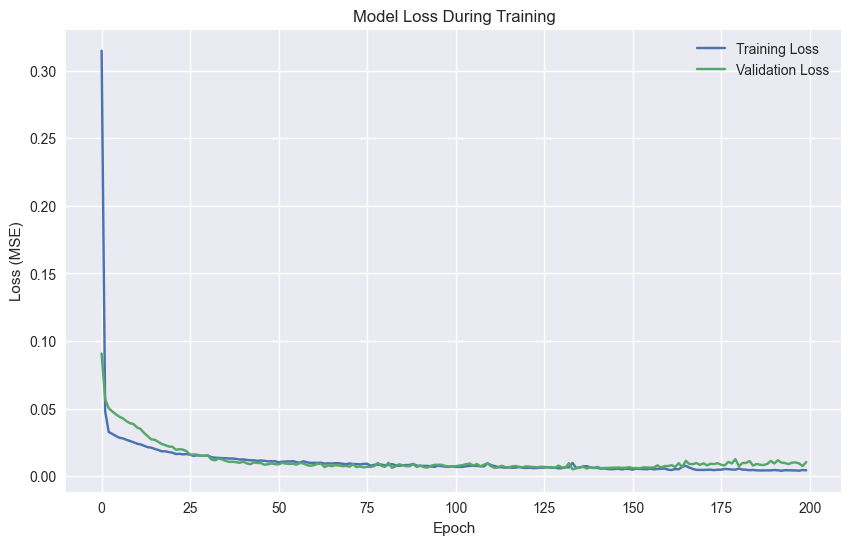

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
# Predict on validation data - Shape: (n_samples, n_steps_out)
predictions_scaled = model.predict(X_valid)

# We still want the prediction for the 4th week ahead (index 3)
predictions_scaled_h4 = predictions_scaled[:, N_STEPS_OUT - 1] # Shape: (n_samples,)

# Inverse transform using scaler_y - requires 2D input
# Reshape predictions_scaled_h4 to (n_samples, 1)
predictions_raw = scaler_y.inverse_transform(predictions_scaled_h4.reshape(-1, 1))

# Flatten the result back to 1D if needed, or keep as column vector
predictions_raw = predictions_raw.flatten() # Shape: (n_samples,)

# Create a Pandas Series for easier handling and alignment
predictions_raw_series = pd.Series(predictions_raw, index=actual_valid_sequences_target.index, name='LSTM_Raw')

# --- Capping (Same as before) ---
MIN_VAL = 205
predictions_capped = np.maximum(MIN_VAL, predictions_raw_series)
predictions_final = np.minimum(predictions_capped, max_level_valid_sequences)
predictions_final = pd.Series(predictions_final, index=actual_valid_sequences_target.index, name='LSTM_Final')

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000278B21BAB60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Validation MAE (LSTM, h=4, capped): 2.1002
Validation RMSE (LSTM, h=4, capped): 2.5900


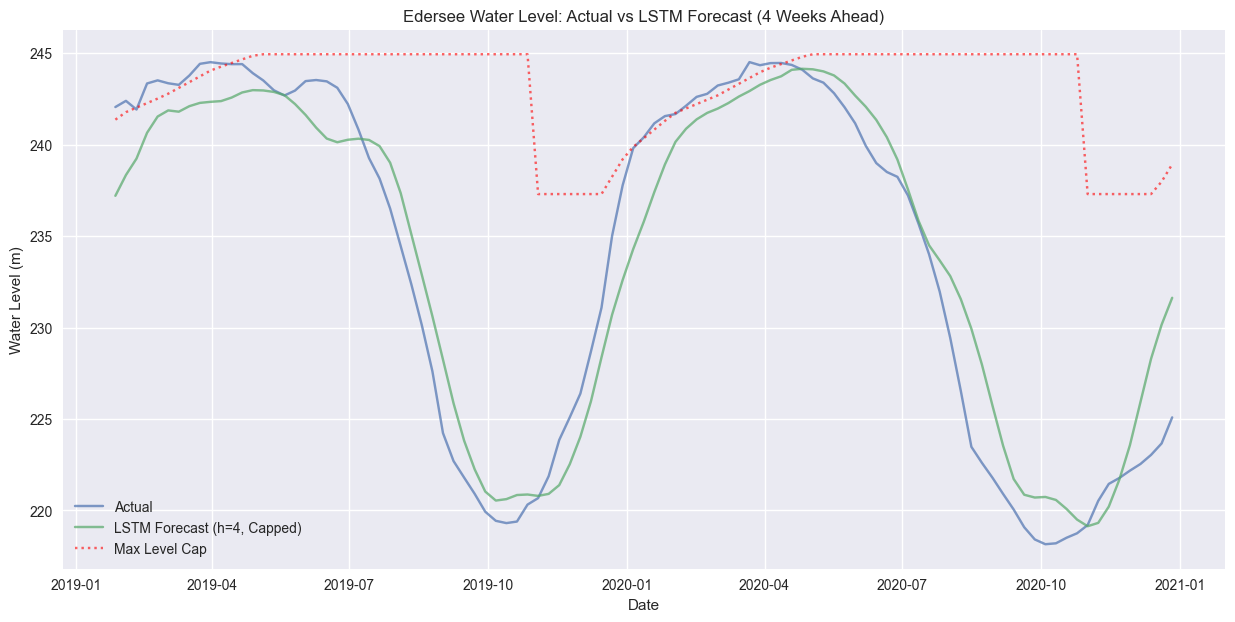

In [92]:
mae = mean_absolute_error(actual_valid_sequences_target, predictions_final)
rmse = np.sqrt(mean_squared_error(actual_valid_sequences_target, predictions_final))

print(f"Validation MAE (LSTM, h=4, capped): {mae:.4f}")
print(f"Validation RMSE (LSTM, h=4, capped): {rmse:.4f}")

# Optional: Plot actual vs predicted
plt.figure(figsize=(15, 7))
plt.plot(actual_valid_sequences_target, label='Actual', alpha=0.7)
plt.plot(predictions_final, label='LSTM Forecast (h=4, Capped)', alpha=0.7)
# plt.plot(predictions_raw_series, label='LSTM Raw', alpha=0.5, linestyle='--') # Optional: plot raw forecast
plt.plot(max_level_valid_sequences, label='Max Level Cap', color='red', linestyle=':', alpha=0.6) # Plot the cap
plt.title('Edersee Water Level: Actual vs LSTM Forecast (4 Weeks Ahead)')
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
mae = mean_absolute_error(actual_valid_sequences_target, predictions_final)
rmse = np.sqrt(mean_squared_error(actual_valid_sequences_target, predictions_final))

print(f"\nValidation MAE (LSTM, h=4, capped, sep. scalers): {mae:.4f}")
print(f"Validation RMSE (LSTM, h=4, capped, sep. scalers): {rmse:.4f}")


Validation MAE (LSTM, h=4, capped, sep. scalers): 2.1002
Validation RMSE (LSTM, h=4, capped, sep. scalers): 2.5900
